In [ ]:
from google.colab import files
upload = files.upload()

Saving utkface_val.zip to utkface_val.zip


In [ ]:
import zipfile
import os

# Specify the name of the uploaded zip file
zip_file_name = "utkface_val.zip"

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("dataset")

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from PIL import Image

In [ ]:
## removing corrupted images , because in previous code i realize that there are images which are corrupted

In [ ]:
import os
import cv2

# Define the directory containing your dataset
dataset_dir = "/content/dataset/utkface_val"

# Function to check if an image file is corrupted
def is_corrupted_image(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return True
        else:
            return False
    except:
        return True

# List to store the names of corrupted images
corrupted_images = []

# Iterate through the dataset directory and subdirectories
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        # Check if the file is an image
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            # Construct the full path to the image file
            image_path = os.path.join(root, file)
            # Check if the image is corrupted
            if is_corrupted_image(image_path):
                corrupted_images.append(image_path)
                # Remove the corrupted image file
                os.remove(image_path)

# Print the names of corrupted images
print("Corrupted images:")
for image_path in corrupted_images:
    print(image_path)

Corrupted images:


In [ ]:
# splitting the dataset

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

# The dataset directory
input_folder = '/content/dataset/utkface_val'
# splitted dataset directory
output = 'splitted_dataset'

# Split with a ratio of 70-15-15
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .15, .15))

Copying files: 4402 files [00:00, 7402.95 files/s]


# **VGG16**

In [ ]:
## VGG 16

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam

In [ ]:
# Define paths to the dataset directories
train_dir = '/content/splitted_dataset/train'
validation_dir = '/content/splitted_dataset/val'
test_dir = '/content/splitted_dataset/test'


num_classes = 4

# Define image dimensions
img_height, img_width = 128, 128
batch_size = 32

# Create data generators without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3080 images belonging to 4 classes.
Found 658 images belonging to 4 classes.


In [ ]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


# Evaluate the model on the test set
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/10
96/96 [==============================] - 14s 74ms/step - loss: 1.1580 - accuracy: 0.5023 - val_loss: 0.9565 - val_accuracy: 0.5922
Epoch 2/10
96/96 [==============================] - 5s 50ms/step - loss: 0.8738 - accuracy: 0.6486 - val_loss: 0.8769 - val_accuracy: 0.6391
Epoch 3/10
96/96 [==============================] - 5s 54ms/step - loss: 0.7907 - accuracy: 0.6932 - val_loss: 0.7712 - val_accuracy: 0.7000
Epoch 4/10
96/96 [==============================] - 5s 55ms/step - loss: 0.7199 - accuracy: 0.7218 - val_loss: 0.7839 - val_accuracy: 0.6891
Epoch 5/10
96/96 [==============================] - 5s 55ms/step - loss: 0.6350 - accuracy: 0.7648 - val_loss: 0.7445 - val_accuracy: 0.7016
Epoch 6/10
96/96 [==============================] - 5s 51ms/step - loss: 0.5904 - accuracy: 0.7772 - val_loss: 0.8176 - val_accuracy: 0.6516
Epoch 7/10
96/96 [==============================] - 5s 52ms/step - loss: 0.5531 - accuracy: 0.7982 - val_loss: 0.6948 - val_accuracy: 0.7156
Epoch 8/10
9

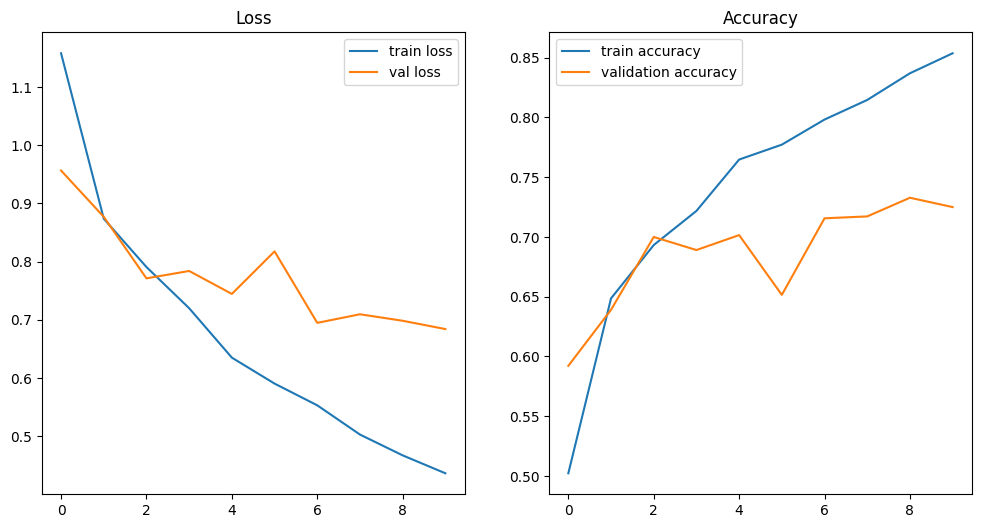

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## trying VGG16 with 20 epochs

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


# Evaluate the model on the test set
test_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Epoch 1/20
96/96 [==============================] - 7s 70ms/step - loss: 0.3965 - accuracy: 0.8688 - val_loss: 0.6870 - val_accuracy: 0.7312
Epoch 2/20
96/96 [==============================] - 5s 54ms/step - loss: 0.3867 - accuracy: 0.8753 - val_loss: 0.6885 - val_accuracy: 0.7328
Epoch 3/20
96/96 [==============================] - 5s 54ms/step - loss: 0.3549 - accuracy: 0.8848 - val_loss: 0.6670 - val_accuracy: 0.7391
Epoch 4/20
96/96 [==============================] - 5s 54ms/step - loss: 0.3172 - accuracy: 0.9016 - val_loss: 0.7107 - val_accuracy: 0.7391
Epoch 5/20
96/96 [==============================] - 5s 55ms/step - loss: 0.2946 - accuracy: 0.9055 - val_loss: 0.6765 - val_accuracy: 0.7359
Epoch 6/20
96/96 [==============================] - 5s 55ms/step - loss: 0.2733 - accuracy: 0.9236 - val_loss: 0.7331 - val_accuracy: 0.7453
Epoch 7/20
96/96 [==============================] - 5s 55ms/step - loss: 0.2696 - accuracy: 0.9213 - val_loss: 0.7046 - val_accuracy: 0.7422
Epoch 8/20
96

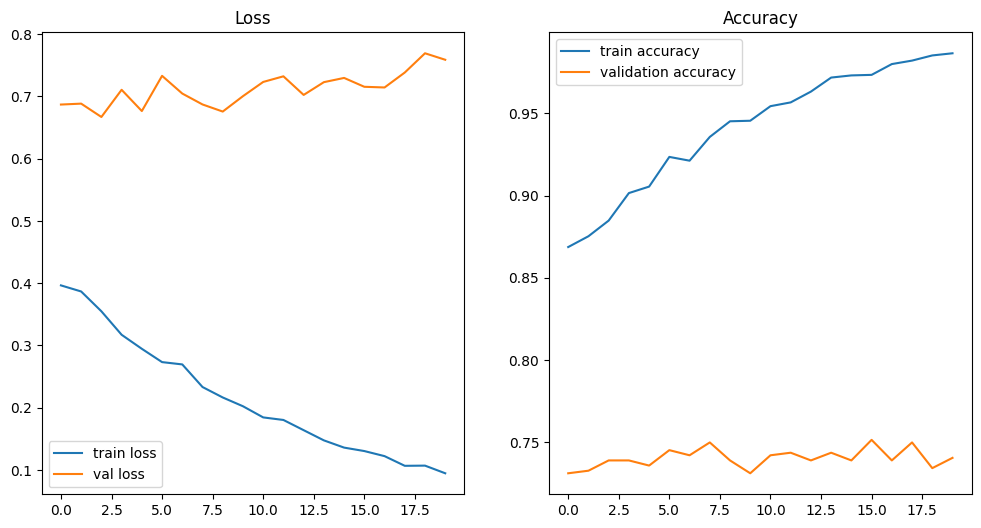

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## prediction

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

def load_and_prepare_image(image_path):
    img = image.load_img(image_path, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)

In [ ]:
def predict_image(model, image_path):
    processed_image = load_and_prepare_image(image_path)
    predictions = model.predict(processed_image)
    return predictions

In [ ]:
def get_prediction_percentage(predictions):
    class_labels = ['white', 'black', 'asian', 'indian'] # Ensure labels are ordered correctly as per your model's training
    percentages = predictions[0] * 100  # Convert probabilities to percentages
    confidence_dict = {label: float(conf) for label, conf in zip(class_labels, percentages)}
    return confidence_dict

In [ ]:
def get_prediction_label_test(predictions):
    class_labels = ['white', 'black','asian', 'indian']  # Adjust based on how your folders are labeled and the order of classes
    predicted_class = class_labels[np.argmax(predictions)]
    return predicted_class

In [ ]:
from google.colab import files
upload = files.upload()

Saving ethnicity-dataset_and_utkface.zip to ethnicity-dataset_and_utkface.zip


In [ ]:
import zipfile
import os

# Specify the name of the uploaded zip file
zip_file_name = "ethnicity-dataset_and_utkface.zip"

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("test")

In [ ]:
image_path = '/content/test/ethnicity-dataset_and_utkface/2/32_1_2_20170116191622164.jpg.chip.jpg'  # Path to new image
predictions = predict_image(model, image_path)
confidence_levels = get_prediction_percentage(predictions)

1/1 [==============================] - 0s 28ms/step


In [ ]:
print("Confidence levels:")
for label, confidence in confidence_levels.items():
    print(f"{label}: {confidence:.2f}%")

Confidence levels:
white: 0.01%
black: 99.99%
asian: 0.00%
indian: 0.00%


# **DenseNet 169**

In [ ]:
############# using Densenet169

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
from keras.applications import DenseNet169
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# Define paths to the dataset directories
train_dir = '/content/splitted_dataset/train'
validation_dir = '/content/splitted_dataset/val'
test_dir = '/content/splitted_dataset/test'

num_classes = 4
img_height, img_width = 224, 224
batch_size = 32

# Load the pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add a logistic layer with softmax activation for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
results = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=20
)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Found 3080 images belonging to 4 classes.
Found 658 images belonging to 4 classes.
Epoch 1/20
96/96 [==============================] - 27s 175ms/step - loss: 1.0150 - accuracy: 0.5991 - val_loss: 0.9685 - val_accuracy: 0.6172
Epoch 2/20
96/96 [==============================] - 14s 147ms/step - loss: 0.7842 - accuracy: 0.6965 - val_loss: 0.7947 - val_accuracy: 0.7063
Epoch 3/20
96/96 [==============================] - 14s 146ms/step - loss: 0.6566 - accuracy: 0.7438 - val_loss: 0.7570 - val_accuracy: 0.7219
Epoch 4/20
96/96 [==============================] - 14s 145ms/step - loss: 0.5933 - accuracy: 0.7746 - val_loss: 0.7561 - val_accuracy: 0.7172
Epoch 5/20
96/96 [==============================] - 14s 147ms/step - loss: 0.6013 - accuracy: 0.7690 - val_loss: 0.8747 - val_accuracy: 0.7016
Epoch 6/20
96/96 [==============================] - 14s 145ms/step - loss: 0.5168 - accuracy: 0.8058 - val_loss: 0.9318 - val_accuracy: 0.6547
Epoch 7/20
96/96 [==============================] - 14s 148

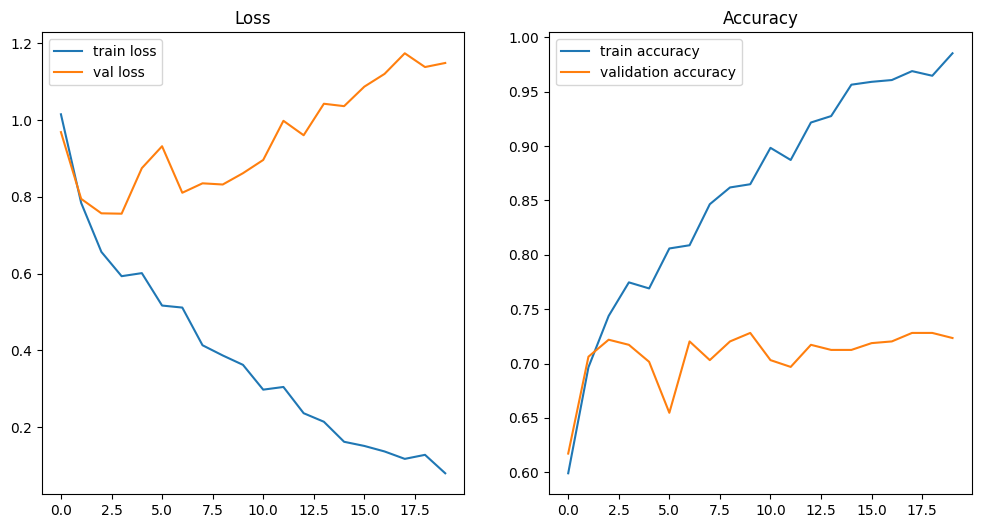

In [ ]:

# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='train accuracy')
plt.plot(results.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
## When you observe a situation where the training loss decreases while the validation loss increases,
# it's typically an indication of overfitting. Overfitting occurs when your model learns to fit the training data too well,
# including the noise and random fluctuations in the data, which may not generalize well to unseen data.

In [ ]:
image_path = '/content/113.jpg'  # Path to new image
predictions = predict_image(model, image_path)
confidence_levels = get_prediction_percentage(predictions)

1/1 [==============================] - 0s 34ms/step


In [ ]:
print("Confidence levels:")
for label, confidence in confidence_levels.items():
    print(f"{label}: {confidence:.2f}%")

Confidence levels:
white: 0.00%
black: 0.00%
asian: 0.00%
indian: 100.00%


In [ ]:
# Evaluate the model on the test set

test_dir = '/content/test/ethnicity-dataset_and_utkface'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Found 240 images belonging to 4 classes.
8/8 [==============================] - 7s 839ms/step - loss: 5.7132 - accuracy: 0.2250
Test Accuracy: 0.22499999403953552
Test Loss: 5.713191509246826


In [ ]:
## changing the image size

In [ ]:
from keras.applications import DenseNet169
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# Define paths to the dataset directories
train_dir = '/content/splitted_dataset/train'
validation_dir = '/content/splitted_dataset/val'
test_dir = '/content/splitted_dataset/test'

num_classes = 4
img_height, img_width = 128, 128
batch_size = 32

# Load the pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False)

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)

# Add a logistic layer with softmax activation for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data generators without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Train the model
results = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=20
)

# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Found 3080 images belonging to 4 classes.
Found 658 images belonging to 4 classes.
Epoch 1/20
96/96 [==============================] - 25s 121ms/step - loss: 1.1397 - accuracy: 0.5909 - val_loss: 0.7945 - val_accuracy: 0.6875
Epoch 2/20
96/96 [==============================] - 7s 68ms/step - loss: 0.7438 - accuracy: 0.7031 - val_loss: 0.7962 - val_accuracy: 0.6906
Epoch 3/20
96/96 [==============================] - 6s 62ms/step - loss: 0.6288 - accuracy: 0.7621 - val_loss: 0.6916 - val_accuracy: 0.7406
Epoch 4/20
96/96 [==============================] - 6s 58ms/step - loss: 0.5229 - accuracy: 0.8091 - val_loss: 0.7685 - val_accuracy: 0.7297
Epoch 5/20
96/96 [==============================] - 6s 64ms/step - loss: 0.4761 - accuracy: 0.8235 - val_loss: 0.7243 - val_accuracy: 0.7250
Epoch 6/20
96/96 [==============================] - 6s 65ms/step - loss: 0.4050 - accuracy: 0.8520 - val_loss: 0.7888 - val_accuracy: 0.7312
Epoch 7/20
96/96 [==============================] - 6s 58ms/step - lo

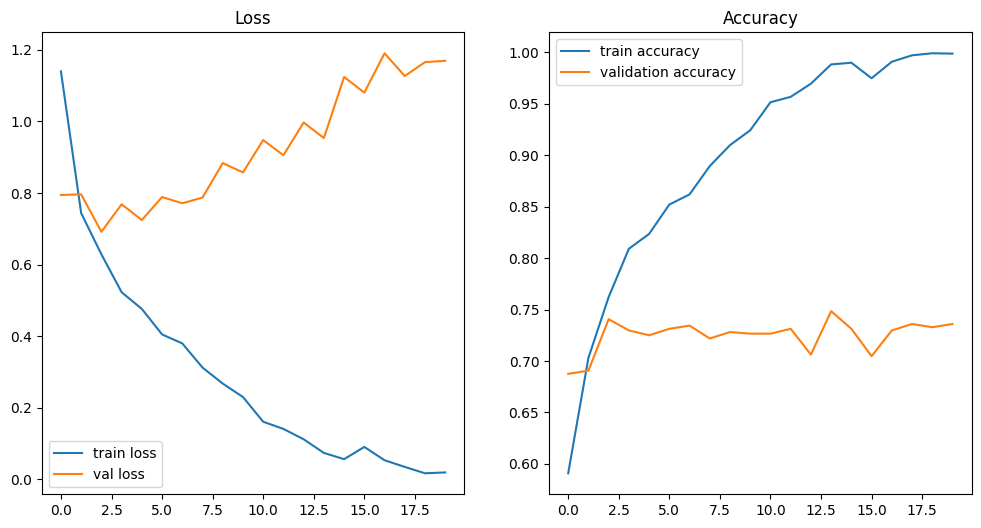

In [ ]:
# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'], label='train loss')
plt.plot(results.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'], label='train accuracy')
plt.plot(results.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()

In [ ]:
image_path = '/content/14.jpeg'  # Path to new image
predictions = predict_image(model, image_path)
confidence_levels = get_prediction_percentage(predictions)

1/1 [==============================] - 0s 86ms/step


In [ ]:
print("Confidence levels:")
for label, confidence in confidence_levels.items():
    print(f"{label}: {confidence:.2f}%")

Confidence levels:
white: 0.00%
black: 0.00%
asian: 0.00%
indian: 100.00%


In [ ]:
# Evaluate the model on the test set

test_dir = '/content/test/ethnicity-dataset_and_utkface'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


# Get the evaluation metrics
evaluation = model.evaluate(test_generator)
print("Test Accuracy:", evaluation[1])
print("Test Loss:", evaluation[0])

Found 240 images belonging to 4 classes.
8/8 [==============================] - 5s 657ms/step - loss: 6.7243 - accuracy: 0.2792
Test Accuracy: 0.27916666865348816
Test Loss: 6.724300861358643
